<a href="https://colab.research.google.com/github/saptarshimazumdar/deep-learning-concepts/blob/main/feed-forward/network-depth-comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## **Question 1**
**Effect of Network Depth on Learning Performance**

In this question, you will study how the depth of a neural network affects learning and generalization. You must implement all models from scratch using NumPy only. The use of sklearn, torch, or tensorflow for model implementation is strictly prohibited.

* Dataset Generation and Experimental Setup: Generate a synthetic binary classification dataset as follows:
    * Input space: $x = (x_1, x_2) \in \mathbb{R}^2$
    * Number of samples: $N = 1000$
    * Class labels: $y \in \{0, 1\}$
    * Data generation rule: $$y = \begin{cases} 1, & \text{if } (x_1^2 + x_2^2) > 0.5 \\ 0, & \text{otherwise} \end{cases}$$
    

where $(x_1, x_2)$ are sampled uniformly from $[-1, 1] \times [-1, 1]$.
    
* Split the dataset into:

    * Training set: 80% of the data
    * Test set: 20% of the data
    
Plot the dataset and explain why a linear classifier cannot solve this problem.

In [ ]:
np.random.seed(42)
N = 1000
data_range = (-1, 1)

In [ ]:
rng = np.random.default_rng()
X = rng.uniform(low=data_range[0], high=data_range[1], size=(N, 2))
x1 = X[:, 0]
x2 = X[:, 1]
division = ((np.pow(x1, 2) + np.pow(x2, 2)) > 0.5)
y = division.astype(int)
indices = np.arange(N)
np.random.shuffle(indices)

train_idx, test_idx = indices[:800], indices[800:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

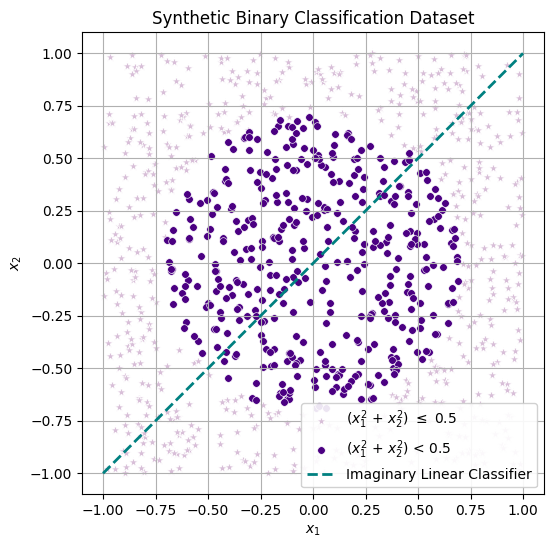

In [ ]:
reference_linear_classifier = np.linspace(data_range[0], data_range[1], N)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=x1[division], y=x2[division], label=r"($x_1^2$ + $x_2^2$) $\leq$ 0.5", marker="*", s=50, c="thistle")
sns.scatterplot(x=x1[~division], y=x2[~division], label="($x_1^2$ + $x_2^2$) < 0.5", s=30, c="indigo")
sns.lineplot(x=reference_linear_classifier, y=reference_linear_classifier, linestyle='--', color='teal', linewidth=2, label="Imaginary Linear Classifier")
plt.title("Synthetic Binary Classification Dataset")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid()
plt.legend(loc='lower right', framealpha=0.9)
plt.gca().set_aspect('equal')
plt.show()

A linear classifier attempts to separate classes using a straight line (a hyperplane in higher dimensions) defined by an equation like $w_1x_1 + w_2x_2 + b = 0$ (For the above example, I have used $x_1 = x_2$).

1. **Non-Linear Decision Boundary:** The data generation rule $(x_1^2 + x_2^2) > 0.5$ describes a circle with a radius of $\sqrt{0.5} \approx 0.707$.
2. **Geometry:** Class ($x_1^2$ + $x_2^2$) > 0.5 is concentrated in the center (the "hole" of the donut), while Class ($x_1^2$ + $x_2^2$) $\leq$ 0.5 surrounds it. There is no single straight line that can separate a central cluster from an outer ring without misclassifying a significant portion of the data.

In [ ]:
def relu(z): return np.maximum(0, z)
def relu_deriv(z): return (z > 0).astype(float)
def sigmoid(z): return 1 / (1 + np.exp(-z))

def bce_loss(y_true, y_pred):
  epsilon = 1e-15
  y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
  return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

### **Binary Cross Entropy Loss Gradient Derivation**

$L = -(y \log(A) + (1-y) \log(1-A))$

* $L$ : BCS Loss
* $Z$ : Pre-activation output
* $A$ : Prediction ($\sigma(Z) = \frac{1}{1+e^{-Z}}$)
* *y* : Actual Labels

<br />

$\frac{\partial L}{\partial Z} = \frac{\partial L}{\partial A} \cdot \frac{\partial A}{\partial Z}$

$\frac{\partial L}{\partial A} = -\left( \frac{y}{A} - \frac{1-y}{1-A} \right) = \frac{A - y}{A(1-A)}$

$\frac{\partial A}{\partial Z} = {A(1-A)}$

$\frac{\partial L}{\partial Z} = {\left( \frac{A - y}{A(1-A)} \right)} \cdot (A(1-A))$

$\frac{\partial L}{\partial Z} = A - y$

In [ ]:
class WeightInitialization:
  @staticmethod
  def get_weights(initialization_type, shape):
    np.random.seed(2)
    # shape is (input_dim, output_dim)
    n_in, n_out = shape
    match initialization_type:
      case 'xavier' | 'tanh' | 'sigmoid':
        std = np.sqrt(2 / (n_in + n_out))
        return np.random.normal(0, std, shape)
      case 'kaiming_he' | 'relu' | 'leaky_relu' | 'elu':
        std = np.sqrt(2 / n_in)
        return np.random.normal(0, std, shape)
      case 'lecun' | 'selu':
        std = np.sqrt(1 / n_in)
        return np.random.normal(0, std, shape)
      case _:
        return np.random.normal(0, 0.1, shape)

In [ ]:
class FeedForwardNeuralNetwork:
  def __init__(self, layers_dims, lr):
    self.params = {}
    self.L = len(layers_dims) - 1
    self.lr = lr
    for i in range(1, len(layers_dims)):
      shape = (layers_dims[i-1], layers_dims[i])
      # All the hidden layers will be ReLU
      self.params[f'W{i}'] = WeightInitialization.get_weights('sigmoid' if i == self.L else 'relu', shape)
      self.params[f'b{i}'] = np.zeros((1, layers_dims[i]))

  def forward_pass(self, X):
    # Hidden layers (ReLU)
    #------ relu(Wx + b) --------
    cache = {'X0': X}
    for i in range(1, self.L):
      cache[f'Z{i}'] = np.dot(cache[f'X{i-1}'], self.params[f'W{i}']) + self.params[f'b{i}']
      cache[f'X{i}'] = relu(cache[f'Z{i}'])

    # Output layer (Sigmoid)
    #-- sigmoid(Wx + b) ---
    cache[f'Z{self.L}'] = np.dot(cache[f'X{self.L-1}'], self.params[f'W{self.L}']) + self.params[f'b{self.L}']
    cache[f'X{self.L}'] = sigmoid(cache[f'Z{self.L}'])
    return cache[f'X{self.L}'], cache

  def backpropagation(self, y, cache):
    m = y.shape[0]
    grads = {}

    # Output layer (Sigmoid)
    # dL/dz -> Sigmoid + BCE Loss === (Last layer (A) - y)
    dA = cache[f'X{self.L}'] - y.reshape(m, 1)

    for i in range(self.L, 0, -1):
      grads[f'dW{i}'] = np.dot(cache[f'X{i-1}'].T, dA) / m
      grads[f'db{i}'] = np.sum(dA, axis=0, keepdims=True) / m

      if i > 1: # Backprop through ReLU
          dA = np.dot(dA, self.params[f'W{i}'].T) * relu_deriv(cache[f'Z{i-1}'])

      # Update parameters (Batch Gradient Descent)
      self.params[f'W{i}'] -= self.lr * grads[f'dW{i}']
      self.params[f'b{i}'] -= self.lr * grads[f'db{i}']

  def fit_predict(self, X_test, y_test):
    probs, _ = self.forward_pass(X_test)
    return np.mean((probs > 0.5).astype(int).flatten() == y_test)

  def predict(self, X_test):
    probs, _ = self.forward_pass(X_test)
    return (probs > 0.5).astype(int).flatten()

  @staticmethod
  def fit(dims, _X, _y, epochs=100, lr=0.01):
    _X_train  = _X[0]
    _X_test   = _X[1]
    _y_train  = _y[0]
    _y_test   = _y[1]
    nn = FeedForwardNeuralNetwork(dims, lr)
    loss_history = []
    pred_history_training = []
    pred_history_testing = []
    for _ in tqdm(range(epochs)):
        _y_pred, cache = nn.forward_pass(_X_train)
        loss = bce_loss(_y_train, _y_pred)
        loss_history.append(loss)
        nn.backpropagation(_y_train, cache)
        pred_history_training.append(nn.fit_predict(_X_train, _y_train))
        pred_history_testing.append(nn.fit_predict(_X_test, _y_test))
    return nn, loss_history, pred_history_training, pred_history_testing

In [ ]:
model1_dims = [2, 20, 1]
model2_dims = [2, 10, 10, 1]

nn1, loss1, training_accuracy1, testing_accuracy1 = FeedForwardNeuralNetwork.fit(model1_dims, (X_train, X_test), (y_train, y_test))
nn2, loss2, training_accuracy2, testing_accuracy2 = FeedForwardNeuralNetwork.fit(model2_dims, (X_train, X_test), (y_train, y_test))

100%|██████████| 100/100 [00:00<00:00, 151.60it/s]


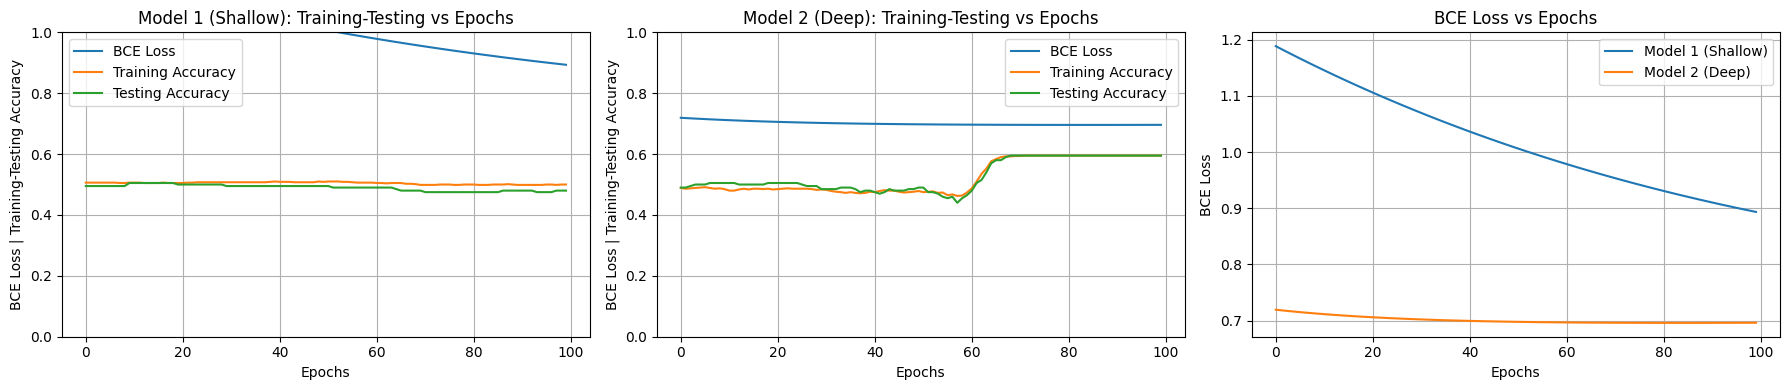

In [ ]:
# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot for Model 1 (Shallow) on the first subplot
axes[0].plot(loss1, label='BCE Loss')
axes[0].plot(training_accuracy1, label='Training Accuracy')
axes[0].plot(testing_accuracy1, label='Testing Accuracy')
axes[0].set_title("Model 1 (Shallow): Training-Testing vs Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("BCE Loss | Training-Testing Accuracy")
axes[0].set_ylim(0, 1)
axes[0].grid(which='both')
axes[0].legend()

# Plot for Model 2 (Deep) on the second subplot
axes[1].plot(loss2, label='BCE Loss')
axes[1].plot(training_accuracy2, label='Training Accuracy')
axes[1].plot(testing_accuracy2, label='Testing Accuracy')
axes[1].set_title("Model 2 (Deep): Training-Testing vs Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("BCE Loss | Training-Testing Accuracy")
axes[1].set_ylim(0, 1)
axes[1].grid(which='both')
axes[1].legend()

# Plot for Model 1 (Shallow) vs Model 2 (Deep) BCE Loss
axes[2].plot(loss1, label='Model 1 (Shallow)')
axes[2].plot(loss2, label='Model 2 (Deep)')
axes[2].set_title("BCE Loss vs Epochs")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("BCE Loss")
axes[2].grid(which='both')
axes[2].legend()

plt.tight_layout()
plt.show()

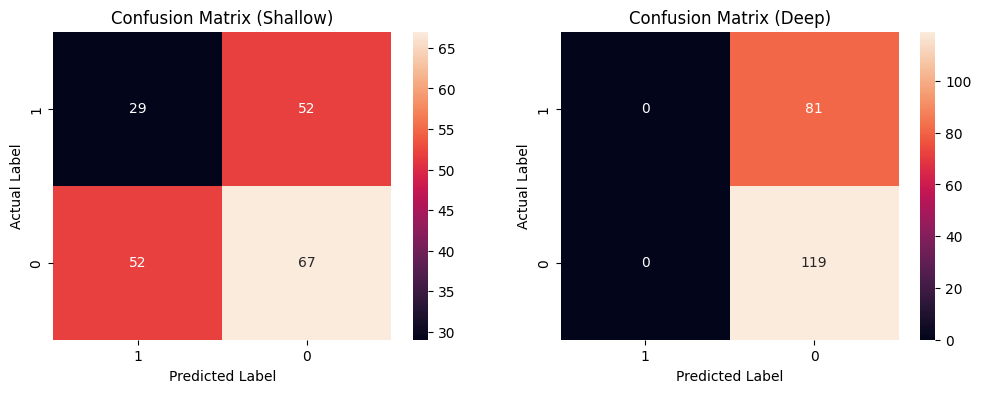


Shallow NN Classification Report
              precision    recall  f1-score   support

           0       0.36      0.36      0.36        81
           1       0.56      0.56      0.56       119

    accuracy                           0.48       200
   macro avg       0.46      0.46      0.46       200
weighted avg       0.48      0.48      0.48       200


Deep NN Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        81
           1       0.59      1.00      0.75       119

    accuracy                           0.59       200
   macro avg       0.80      0.50      0.37       200
weighted avg       0.76      0.59      0.44       200



In [ ]:
display_labels = ['1', '0']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot=0
y_pred_shallow = nn1.predict(X_test)
cm = confusion_matrix(y_test, y_pred_shallow)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=display_labels, yticklabels=display_labels, ax=axes[plot])
axes[plot].set_xlabel('Predicted Label')
axes[plot].set_ylabel('Actual Label')
axes[plot].set_title('Confusion Matrix (Shallow)')

plot=1
y_pred_deep = nn2.predict(X_test)
cm = confusion_matrix(y_test, y_pred_deep)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=display_labels, yticklabels=display_labels, ax=axes[plot])
axes[plot].set_xlabel('Predicted Label')
axes[plot].set_ylabel('Actual Label')
axes[plot].set_title('Confusion Matrix (Deep)')

plt.show()

print()
print("Shallow NN Classification Report")
print(classification_report(y_test, y_pred_shallow, target_names=display_labels[::-1], zero_division=1))
print()
print("Deep NN Classification Report")
print(classification_report(y_test, y_pred_deep, target_names=display_labels[::-1], zero_division=1))

### **Model Comparison**

<table>
   <tr>
      <th>Models/Factors</th>
      <th>Model 1 (Shallow)</th>
      <th>Model 2 (Deep)</th>
      <th>Selection</th>
   </tr>
   <tr>
      <td>Representational Capacity</td>
      <td>With only 20 neurons, its "breadth" allows it to memorize specific features but lacks hierarchical mapping</td>
      <td>Deeper networks can represent more complex functions with fewer total parameters than shallow ones.</td>
      <td>Model 2</td>
   </tr>
   <tr>
      <td>Optimization Difficulty</td>
      <td>Generally easier to train. With fewer layers, the gradient of the loss function <br/> has a shorter path to travel back to the input weights.</td>
      <td>Even with only two hidden layers, optimization becomes slightly more complex. Each additional layer introduces more <br/> non-linearities (ReLU) and more multiplication steps during backpropagation</td>
      <td>Model 1</td>
   </tr>
   <tr>
      <td>Generalization Performance</td>
      <td>Shallow, wide networks are prone to memorization. With 20 neurons in one layer, <br /> it might fit the training noise rather than the underlying signal.</td>
      <td>Depth acts as a form of regularization. By forcing the data through bottlenecks (10 neurons instead of 20),<br /> the model is pressured to learn the most salient, generalized features of the data</td>
      <td>Model 2</td>
   </tr>
</table>

### **Extras**
Trying the models to run with 1000 epochs instead of 100 epochs

100%|██████████| 1000/1000 [00:04<00:00, 234.86it/s]


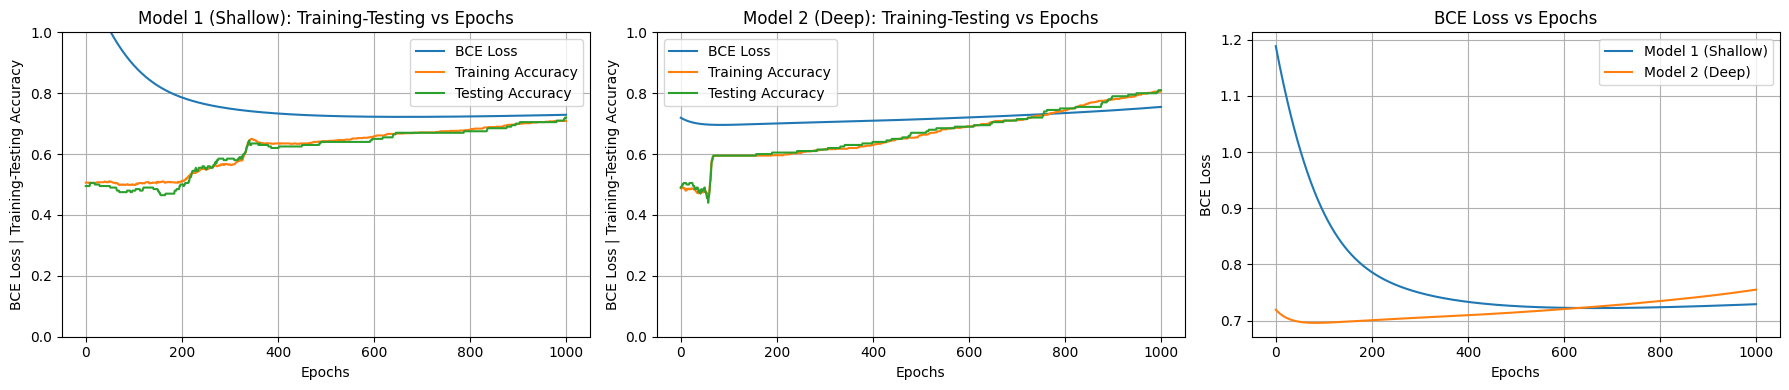

In [ ]:
nn1, loss1, training_accuracy1, testing_accuracy1 = FeedForwardNeuralNetwork.fit(model1_dims, (X_train, X_test), (y_train, y_test), 1000)
nn2, loss2, training_accuracy2, testing_accuracy2 = FeedForwardNeuralNetwork.fit(model2_dims, (X_train, X_test), (y_train, y_test), 1000)

# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot for Model 1 (Shallow) on the first subplot
axes[0].plot(loss1, label='BCE Loss')
axes[0].plot(training_accuracy1, label='Training Accuracy')
axes[0].plot(testing_accuracy1, label='Testing Accuracy')
axes[0].set_title("Model 1 (Shallow): Training-Testing vs Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("BCE Loss | Training-Testing Accuracy")
axes[0].set_ylim(0, 1)
axes[0].grid(which='both')
axes[0].legend()

# Plot for Model 2 (Deep) on the second subplot
axes[1].plot(loss2, label='BCE Loss')
axes[1].plot(training_accuracy2, label='Training Accuracy')
axes[1].plot(testing_accuracy2, label='Testing Accuracy')
axes[1].set_title("Model 2 (Deep): Training-Testing vs Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("BCE Loss | Training-Testing Accuracy")
axes[1].set_ylim(0, 1)
axes[1].grid(which='both')
axes[1].legend()

# Plot for Model 1 (Shallow) vs Model 2 (Deep) BCE Loss
axes[2].plot(loss1, label='Model 1 (Shallow)')
axes[2].plot(loss2, label='Model 2 (Deep)')
axes[2].set_title("BCE Loss vs Epochs")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("BCE Loss")
axes[2].grid(which='both')
axes[2].legend()

plt.tight_layout()
plt.show()

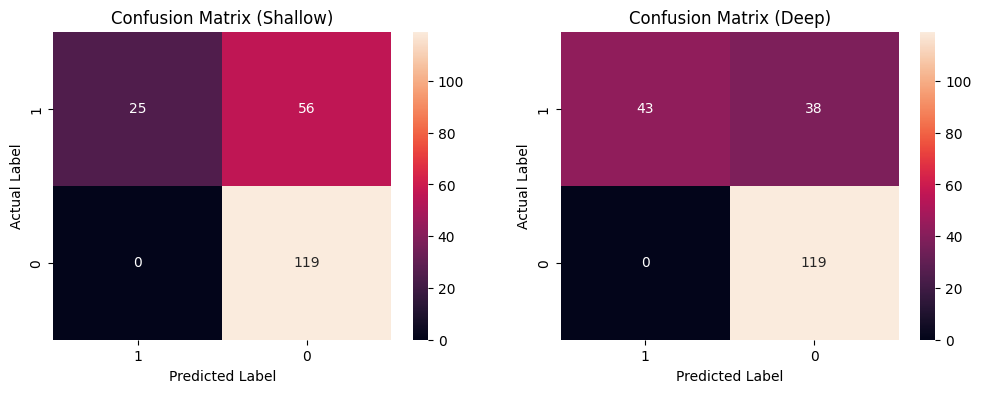


Shallow NN Classification Report
              precision    recall  f1-score   support

           0       1.00      0.31      0.47        81
           1       0.68      1.00      0.81       119

    accuracy                           0.72       200
   macro avg       0.84      0.65      0.64       200
weighted avg       0.81      0.72      0.67       200


Deep NN Classification Report
              precision    recall  f1-score   support

           0       1.00      0.53      0.69        81
           1       0.76      1.00      0.86       119

    accuracy                           0.81       200
   macro avg       0.88      0.77      0.78       200
weighted avg       0.86      0.81      0.79       200



In [ ]:
display_labels = ['1', '0']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot=0
y_pred_shallow = nn1.predict(X_test)
cm = confusion_matrix(y_test, y_pred_shallow)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=display_labels, yticklabels=display_labels, ax=axes[plot])
axes[plot].set_xlabel('Predicted Label')
axes[plot].set_ylabel('Actual Label')
axes[plot].set_title('Confusion Matrix (Shallow)')

plot=1
y_pred_deep = nn2.predict(X_test)
cm = confusion_matrix(y_test, y_pred_deep)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=display_labels, yticklabels=display_labels, ax=axes[plot])
axes[plot].set_xlabel('Predicted Label')
axes[plot].set_ylabel('Actual Label')
axes[plot].set_title('Confusion Matrix (Deep)')

plt.show()

print()
print("Shallow NN Classification Report")
print(classification_report(y_test, y_pred_shallow, target_names=display_labels[::-1]))
print()
print("Deep NN Classification Report")
print(classification_report(y_test, y_pred_deep, target_names=display_labels[::-1]))

### **Extras**
Trying the models to run with 10000 epochs instead of 100 epochs

100%|██████████| 10000/10000 [00:41<00:00, 240.96it/s]


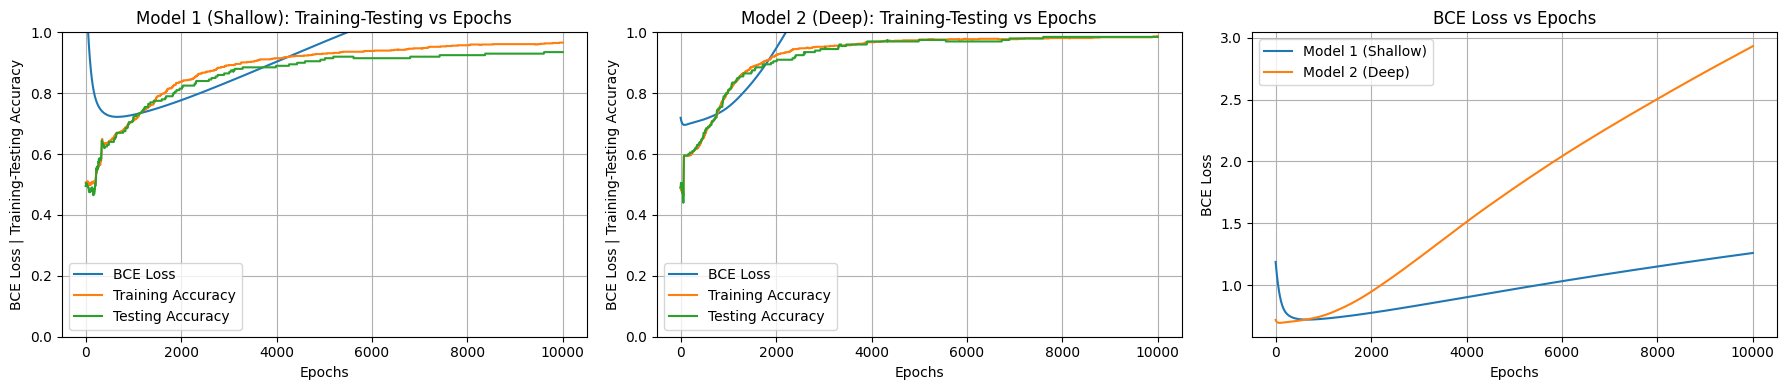

In [ ]:
nn1, loss1, training_accuracy1, testing_accuracy1 = FeedForwardNeuralNetwork.fit(model1_dims, (X_train, X_test), (y_train, y_test), 10000)
nn2, loss2, training_accuracy2, testing_accuracy2 = FeedForwardNeuralNetwork.fit(model2_dims, (X_train, X_test), (y_train, y_test), 10000)

# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot for Model 1 (Shallow) on the first subplot
axes[0].plot(loss1, label='BCE Loss')
axes[0].plot(training_accuracy1, label='Training Accuracy')
axes[0].plot(testing_accuracy1, label='Testing Accuracy')
axes[0].set_title("Model 1 (Shallow): Training-Testing vs Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("BCE Loss | Training-Testing Accuracy")
axes[0].set_ylim(0, 1)
axes[0].grid(which='both')
axes[0].legend()

# Plot for Model 2 (Deep) on the second subplot
axes[1].plot(loss2, label='BCE Loss')
axes[1].plot(training_accuracy2, label='Training Accuracy')
axes[1].plot(testing_accuracy2, label='Testing Accuracy')
axes[1].set_title("Model 2 (Deep): Training-Testing vs Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("BCE Loss | Training-Testing Accuracy")
axes[1].set_ylim(0, 1)
axes[1].grid(which='both')
axes[1].legend()

# Plot for Model 1 (Shallow) vs Model 2 (Deep) BCE Loss
axes[2].plot(loss1, label='Model 1 (Shallow)')
axes[2].plot(loss2, label='Model 2 (Deep)')
axes[2].set_title("BCE Loss vs Epochs")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("BCE Loss")
axes[2].grid(which='both')
axes[2].legend()

plt.tight_layout()
plt.show()

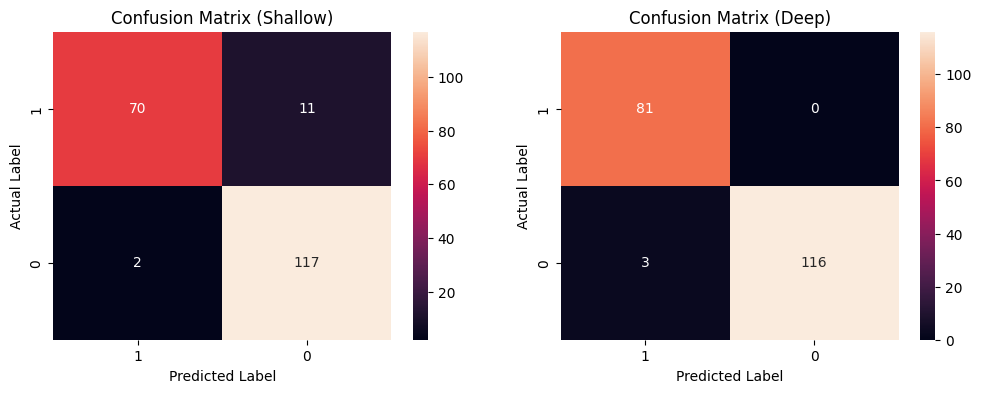


Shallow NN Classification Report
              precision    recall  f1-score   support

           0       0.97      0.86      0.92        81
           1       0.91      0.98      0.95       119

    accuracy                           0.94       200
   macro avg       0.94      0.92      0.93       200
weighted avg       0.94      0.94      0.93       200


Deep NN Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        81
           1       1.00      0.97      0.99       119

    accuracy                           0.98       200
   macro avg       0.98      0.99      0.98       200
weighted avg       0.99      0.98      0.99       200



In [ ]:
display_labels = ['1', '0']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot=0
y_pred_shallow = nn1.predict(X_test)
cm = confusion_matrix(y_test, y_pred_shallow)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=display_labels, yticklabels=display_labels, ax=axes[plot])
axes[plot].set_xlabel('Predicted Label')
axes[plot].set_ylabel('Actual Label')
axes[plot].set_title('Confusion Matrix (Shallow)')

plot=1
y_pred_deep = nn2.predict(X_test)
cm = confusion_matrix(y_test, y_pred_deep)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=display_labels, yticklabels=display_labels, ax=axes[plot])
axes[plot].set_xlabel('Predicted Label')
axes[plot].set_ylabel('Actual Label')
axes[plot].set_title('Confusion Matrix (Deep)')

plt.show()

print()
print("Shallow NN Classification Report")
print(classification_report(y_test, y_pred_shallow, target_names=display_labels[::-1]))
print()
print("Deep NN Classification Report")
print(classification_report(y_test, y_pred_deep, target_names=display_labels[::-1]))